In [ ]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb, lightgbm as lgb
import optuna, shap, warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42

# Load data

In [ ]:

df = pd.read_csv("StressLevelDataset.csv")
print(df.shape)
df.head()

(1100, 21)


,anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,...,basic_needs,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying,stress_level
0,14,20,0,11,2,1,2,4,2,3,...,2,3,2,3,3,2,3,3,2,1
1,15,8,1,15,5,3,1,4,3,1,...,2,1,4,1,5,1,4,5,5,2
2,12,18,1,14,2,1,2,2,2,2,...,2,2,3,3,2,2,3,2,2,1
3,16,12,1,15,4,3,1,3,4,2,...,2,2,4,1,4,1,4,4,5,2
4,16,28,0,7,2,3,5,1,3,2,...,3,4,3,1,2,1,5,0,5,1


# Basic info

In [3]:
# Basic info
display(df.info())

# Missing values
missing = df.isna().sum()
display(missing[missing>0])

# Duplicates
print("Duplicates:", df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   anxiety_level                 1100 non-null   int64
 1   self_esteem                   1100 non-null   int64
 2   mental_health_history         1100 non-null   int64
 3   depression                    1100 non-null   int64
 4   headache                      1100 non-null   int64
 5   blood_pressure                1100 non-null   int64
 6   sleep_quality                 1100 non-null   int64
 7   breathing_problem             1100 non-null   int64
 8   noise_level                   1100 non-null   int64
 9   living_conditions             1100 non-null   int64
 10  safety                        1100 non-null   int64
 11  basic_needs                   1100 non-null   int64
 12  academic_performance          1100 non-null   int64
 13  study_load                    110

None

Series([], dtype: int64)

Duplicates: 0


# 📊 Figure: Distribution of Stress-Level Classes

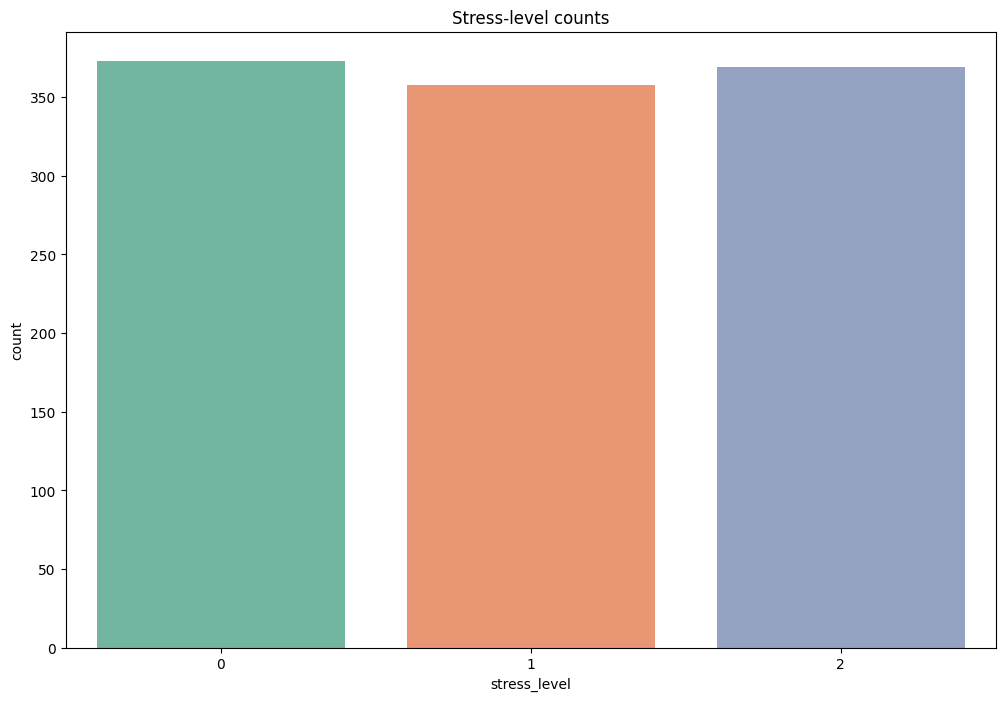

In [34]:
plt.figure(figsize=(12,8))
sns.countplot(x='stress_level', data=df,palette="Set2")
plt.title("Stress-level counts")
plt.show()

# 🔥 Correlation Heatmap – All Numeric Features
##  Purpose
This heatmap visualizes pair-wise Pearson correlations across every numeric column in the dataset.
Use it to:


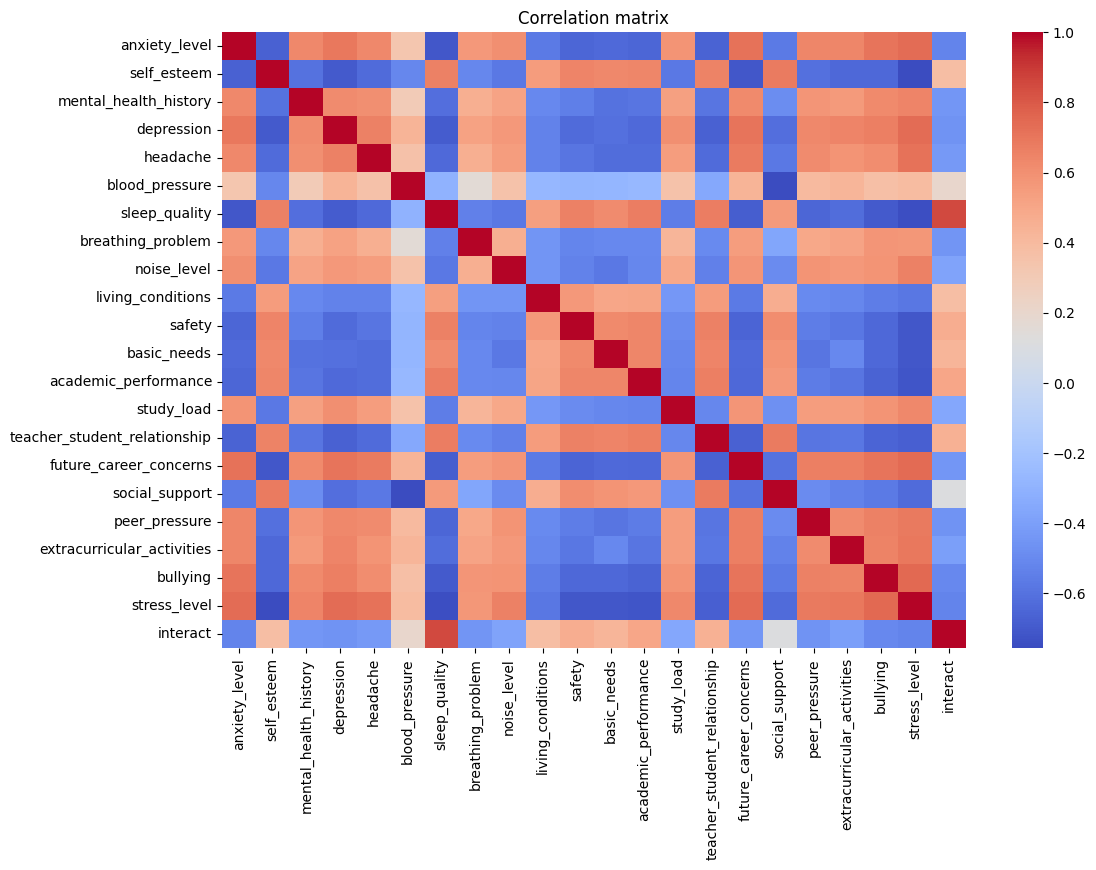

In [35]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', fmt=".1f", annot_kws={'size': 6})
plt.title("Correlation matrix")
plt.show()

# 📊 Stress-Level Distribution – Count vs. Proportion
 ## Purpose
This dual-panel figure provides both absolute counts and relative proportions of the target variable stress_level, making it easy to:

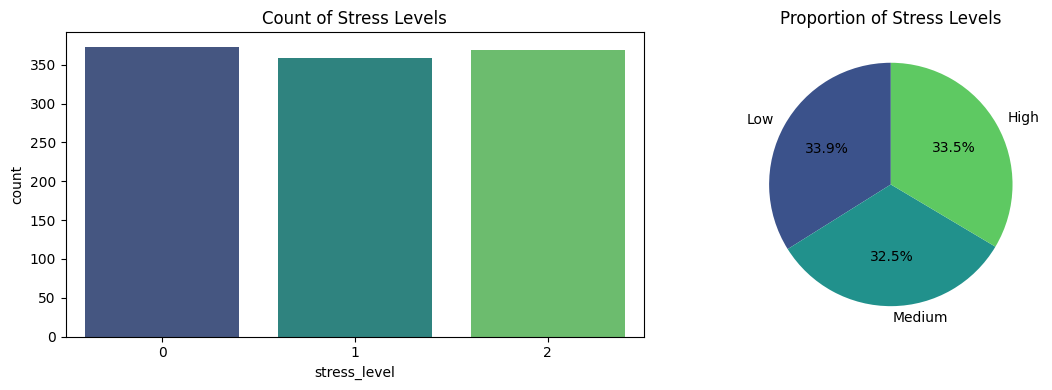

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Bar
sns.countplot(x='stress_level', data=df, ax=ax[0], palette='viridis')
ax[0].set_title("Count of Stress Levels")

# Pie
labels = ["Low", "Medium", "High"]
sizes  = df['stress_level'].value_counts().sort_index()
ax[1].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90,
          colors=sns.color_palette("viridis", 3))
ax[1].set_title("Proportion of Stress Levels")

plt.tight_layout()
plt.show()

# 🔥 Lower-Triangle Correlation Heatmap
##  Purpose
A clean, publication-ready view of pairwise Pearson correlations that removes the redundant upper triangle.

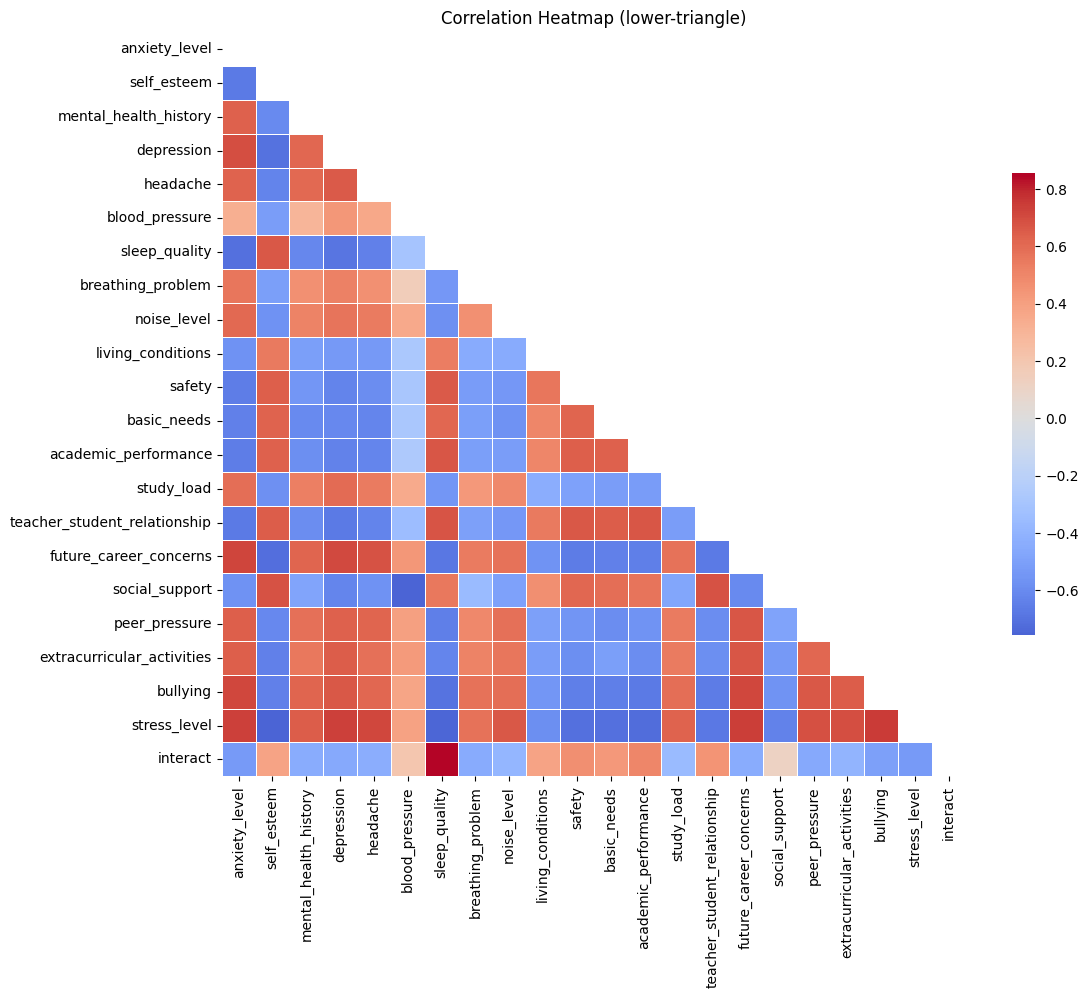

In [28]:
plt.figure(figsize=(12, 10))
corr = df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .6})
plt.title("Correlation Heatmap (lower-triangle)")
plt.show()

# 📈 Kernel-Density Distributions of Top-6 Stress-Level Correlates
## Purpose
Visualize how the six strongest numeric predictors of stress_level are distributed across the three stress classes (Low, Medium, High).

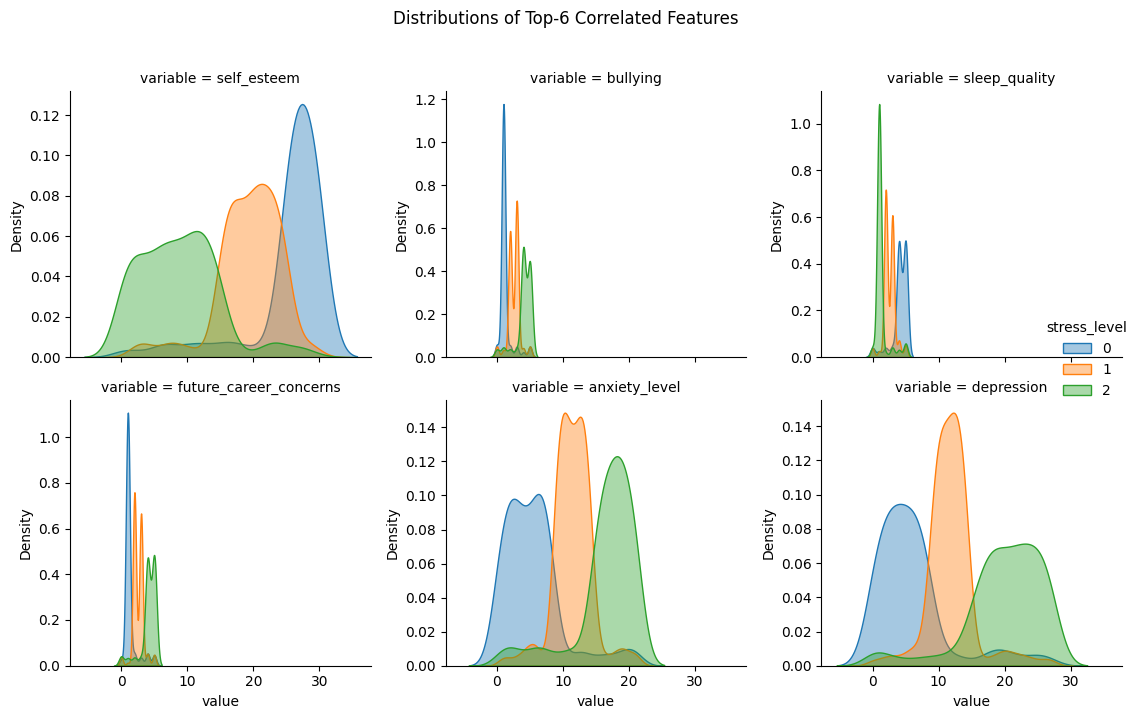

In [29]:
top6 = corr["stress_level"].abs().sort_values(ascending=False).drop("stress_level").head(6).index

g = sns.FacetGrid(pd.melt(df, id_vars='stress_level', value_vars=top6),
                  col="variable", hue="stress_level",
                  col_wrap=3, height=3.5, sharey=False)
g.map(sns.kdeplot, "value", fill=True, alpha=.4)
g.add_legend()
g.fig.suptitle("Distributions of Top-6 Correlated Features", y=1.02)
plt.tight_layout()
plt.show()

# 📦 Boxplot Pair – Anxiety & Depression vs. Stress Level
## Purpose
Side-by-side boxplots compare the central tendency, spread, and outliers of anxiety_level and depression across the three stress classes (Low = 0, Medium = 1, High = 2).

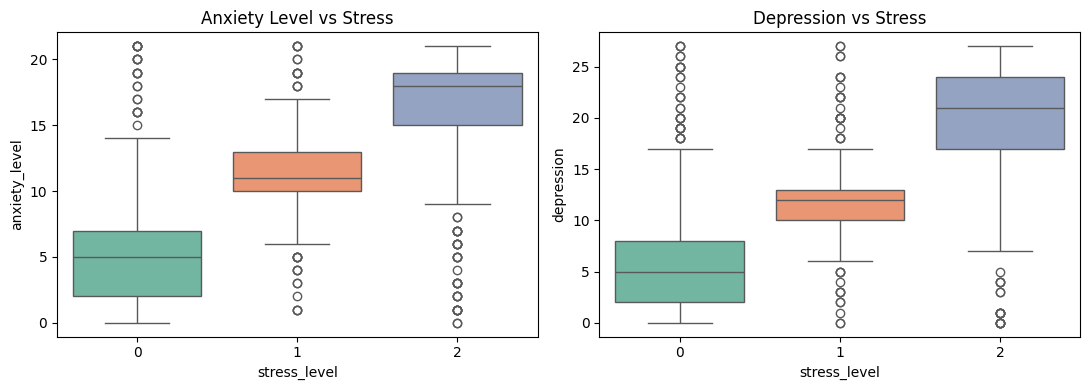

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(11, 4))
sns.boxplot(x='stress_level', y='anxiety_level', data=df, ax=ax[0], palette='Set2')
sns.boxplot(x='stress_level', y='depression',       data=df, ax=ax[1], palette='Set2')
ax[0].set_title("Anxiety Level vs Stress")
ax[1].set_title("Depression vs Stress")
plt.tight_layout()
plt.show()

# 📊 Pairplot – Top-4 Stress-Level Correlates (with Target Overlay)
## Purpose
A 4-dimensional scatter-matrix (plus color overlay) that visualizes all pairwise relationships among the four numeric features most strongly correlated with stress_level, while color-coding points by stress class (Low, Medium, High).

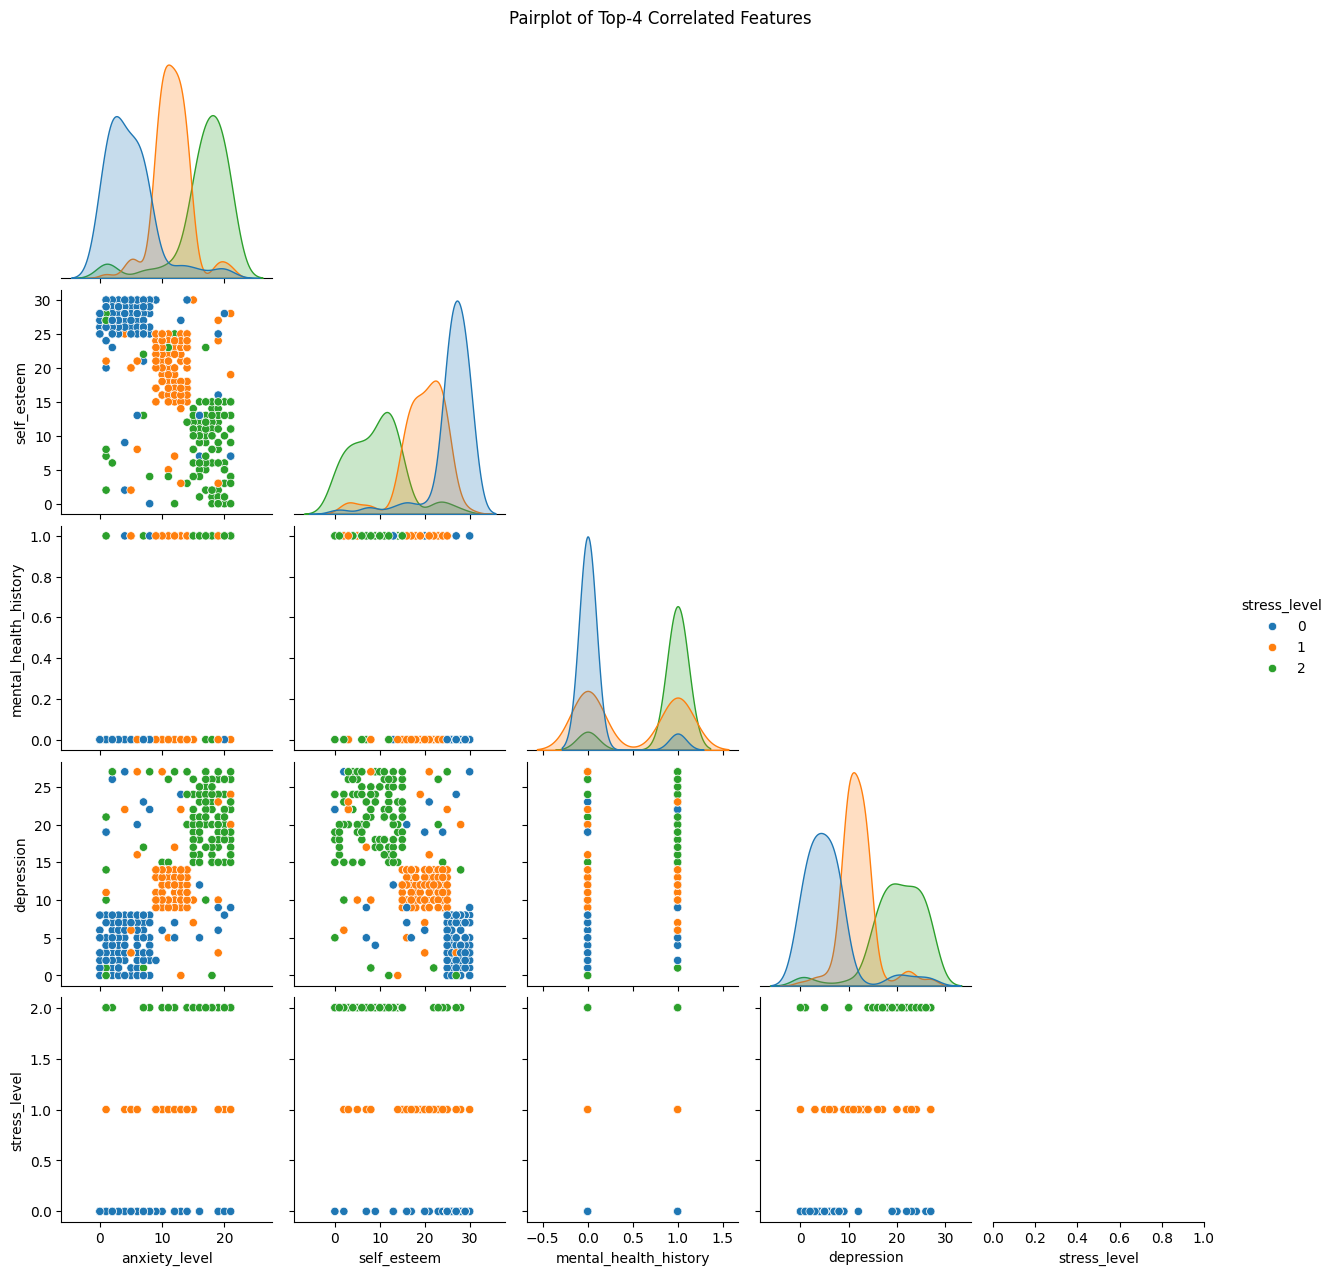

In [31]:
top4 = corr["stress_level"].abs().drop("stress_level").head(4).index.tolist()
sns.pairplot(df.sample(400, random_state=42),
             vars=top4 + ['stress_level'],
             hue='stress_level', corner=True, palette="tab10")
plt.suptitle("Pairplot of Top-4 Correlated Features", y=1.02)
plt.show()

# 🌲 Random-Forest Feature Importance – Top 15 Drivers of Stress
## Purpose
After training a balanced Random-Forest (400 trees), we extract Gini-based importances to rank which variables most influence the model’s ability to discriminate Low vs. Medium vs. High stress.
## This plot:
. Provides an interpretable baseline for feature selection.
. Highlights non-linear or interaction effects that a linear model might miss.
. Guides domain follow-up—e.g., why depression or mental_health_history dominates.

RF ROC-AUC: 0.9845738289659524


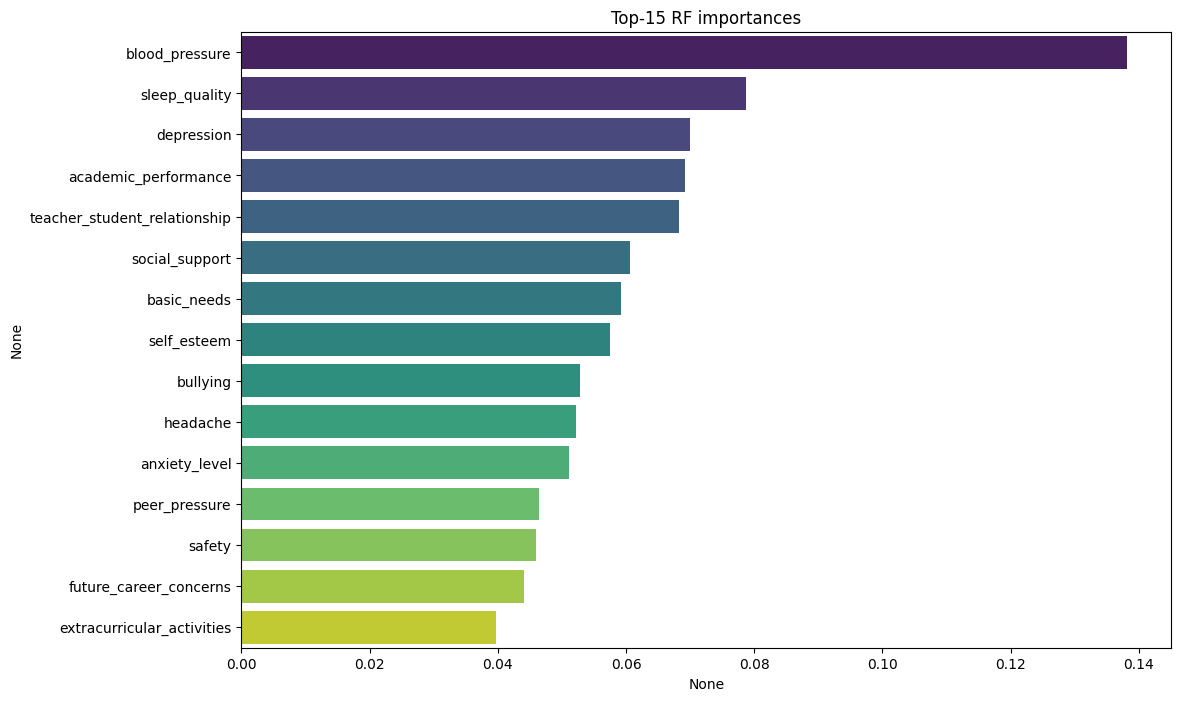

In [33]:
rf = RandomForestClassifier(
    n_estimators=400, max_depth=None, class_weight='balanced',
    random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train, y_train)

print("RF ROC-AUC:", roc_auc_score(
    y_test, rf.predict_proba(X_test), multi_class='ovr'))

# Feature importance
imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(12,8))
sns.barplot(x=imp.head(15), y=imp.head(15).index,palette="viridis")
plt.title("Top-15 RF importances")
plt.show()